In [1]:
import cudf 
import cupy as cp

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def change_dates(df):
    #changes fecha_inicio_sintomas according to new criteria
    filt_df2 = (df.fecha_inicio_sintomas.isnull()) #filter fecha_inicio_sintomas = inexistant
    n_size = (df[filt_df2]).shape[0]
    df["fecha_inicio_sintomas"] = df["fecha_inicio_sintomas"].fillna(0)
    df["fecha_inicio_sintomas"] = df["fecha_inicio_sintomas"].astype('int')
    df["fecha_apertura"] = df["fecha_apertura"].astype('int')
    b = cp.array(df["fecha_apertura"].values)
    a = cp.array(df["fecha_inicio_sintomas"].values)
    a[filt_df2.values] = b[filt_df2.values] - cp.random.randint(0,9,a[filt_df2.values].shape)
    filt_a = cp.where(a<0)
    a[filt_a] = 0
    df = df.drop(["fecha_inicio_sintomas"],axis=1)
    df["fecha_inicio_sintomas"] = a
    return df

## Carga de datos, sacamos las series temporal

In [4]:
direccion = '12en20.csv'
columnas = ['residencia_provincia_nombre','residencia_departamento_nombre','fecha_inicio_sintomas',
            'fecha_apertura','clasificacion_resumen']
data = cudf.read_csv(direccion,sep=",",quotechar='"', usecols=columnas,
                   parse_dates=["fecha_inicio_sintomas","fecha_apertura"],na_values=['']) 

In [5]:
data = data[data["clasificacion_resumen"] == "Confirmado"] #filter confirmed cases
df = cudf.DataFrame(data) 

In [6]:
df = df.drop(['clasificacion_resumen'], axis=1) #drop clasificacion_resumen bc previous filter of confirmed cases

In [7]:
filt_df1 = (df.fecha_inicio_sintomas.notnull()) #filter fecha_inicio_sintomas = inexistant
inicio_epidemia = (df.loc[filt_df1,"fecha_inicio_sintomas"]).min() #first symptoms of a person registered
ultima_actualizacion_sintomas = (df.loc[filt_df1,"fecha_inicio_sintomas"]).max() #last day symptoms of a person registered
ultima_actualizacion_apertura = (df["fecha_apertura"]).max()
df["fecha_inicio_sintomas"] -= inicio_epidemia #correcting by inicio_epidemia 
df["fecha_apertura"] -= inicio_epidemia #correcting by inicio_epidemia
df.fecha_inicio_sintomas = df.fecha_inicio_sintomas.dt.days #change to int, ditch days 
df.fecha_apertura = df.fecha_apertura.dt.days #change to int, ditch days
print("primer sintoma de persona confirmada: ",inicio_epidemia)
print("ultimo sintoma de persona confirmada: ",ultima_actualizacion_sintomas)
print("ultima apertura de persona confirmada: ",ultima_actualizacion_apertura)

primer sintoma de persona confirmada:  2020-01-01T00:00:00.000000000
ultimo sintoma de persona confirmada:  2021-01-11T00:00:00.000000000
ultima apertura de persona confirmada:  2021-01-11T00:00:00.000000000


In [8]:
df = change_dates(df) # we have replaced all bad or undefined dates

In [9]:
#let's list all the provinces that have cases (all rn tbh, but just to use pandas stuff)
#we'll get those times series then, with cudf grouping
provincias = df["residencia_departamento_nombre"].unique()
#print: we get provinces + the sin especificar / unespecified thing
print(provincias)

0      12 de Octubre
1         1º de Mayo
2         2 de Abril
3         25 de Mayo
4         9 de Julio
           ...      
442           Zapala
443            Zonda
444           Zárate
445        Ñorquincó
446          Ñorquín
Name: residencia_departamento_nombre, Length: 447, dtype: object


In [10]:
df = df[["residencia_departamento_nombre","fecha_inicio_sintomas"]]
df2 = df.groupby(["residencia_departamento_nombre","fecha_inicio_sintomas"]).size().reset_index() 
df2 = df2.rename(columns={0:'casos'})
df3 = df2.sort_values(["residencia_departamento_nombre","fecha_inicio_sintomas"],ascending=[True,True])

/home/denise/miniconda3/envs/gpup/lib/python3.7/site-packages/cudf/core/frame.py:2627: UserWarning: When using a sequence of booleans for `ascending`, `na_position` flag is not yet supported and defaults to treating nulls as greater than all numbers
  "When using a sequence of booleans for `ascending`, "


In [11]:
rows = provincias.shape[0]
cols = df2["fecha_inicio_sintomas"].max()
time_series = cp.zeros(shape=(rows,cols))
time_series_ac = cp.zeros(shape=(rows,cols))

In [12]:
j = 0
for i in provincias.to_pandas():
  df_tmp = df3[df3["residencia_departamento_nombre"]==i]
  tmp_dates = cp.array(df_tmp["fecha_inicio_sintomas"].values)
  tmp_cases = cp.array(df_tmp["casos"].values)
  time_series[j,tmp_dates]= tmp_cases
  j = j + 1

In [13]:
for i in range(rows):
  for j in range(13,cols):
    time_series_ac[i,j] = cp.sum(time_series[i,j-13:j+1])

In [14]:
time_series_ac

array([[  0.,   0.,   0., ...,  34.,  30.,  26.],
       [  0.,   0.,   0., ...,   9.,   8.,   8.],
       [  0.,   0.,   0., ...,   2.,   2.,   2.],
       ...,
       [  0.,   0.,   0., ..., 201., 185., 167.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ..., 109., 100.,  85.]])

## Primero, aca vamos a calcular la correlacion de Pearson y chequear que de todo bien

Esto funciona aca y esta todo tranquilo, no hay problema!

In [15]:
#no existe en cupy, la hago yo a esta funcion 
def pearsonr(a,b):
  m_a = cp.mean(a)
  m_b = cp.mean(b)
  r_a = a - m_a
  r_b = b - m_b
  r_a_2 = cp.sum((r_a)**2) 
  r_b_2 = cp.sum((r_b)**2)
  r = cp.sum((r_a*r_b)/cp.sqrt(r_a_2*r_b_2))
  return r

In [16]:
#por ejemplo, correlaciones para caba y baires
caba = time_series_ac[1,:-10]
baires = time_series_ac[0,:-10]
pearsonr(caba,baires)

array(0.3838128)

In [17]:
#ahora, tratemos de hacer lo mismo para baires y el resto del país
baires = time_series_ac[0,:-10]
i = 1
provs = provincias.to_pandas()
print('Coeficientes de Pearson')
while i < rows:
  prov_tmp = time_series_ac[i,:-10]
  r = pearsonr(baires,prov_tmp)
  print('Pearson entre '+provs[i]+' y Baires: ',cp.around(r,3))
  i += 1

Coeficientes de Pearson
Pearson entre 1º de Mayo y Baires:  0.384
Pearson entre 2 de Abril y Baires:  0.714
Pearson entre 25 de Mayo y Baires:  0.609
Pearson entre 9 de Julio y Baires:  0.911
Pearson entre Adolfo Alsina y Baires:  0.622
Pearson entre Adolfo Gonzales Chaves y Baires:  0.704
Pearson entre Aguirre y Baires:  0.486
Pearson entre Albardón y Baires:  0.82
Pearson entre Alberdi y Baires:  0.16
Pearson entre Alberti y Baires:  0.822
Pearson entre Almirante Brown y Baires:  0.143
Pearson entre Aluminé y Baires:  0.858
Pearson entre Ambato y Baires:  0.348
Pearson entre Ancasti y Baires:  0.292
Pearson entre Andalgalá y Baires:  0.475
Pearson entre Angaco y Baires:  0.768
Pearson entre Anta y Baires:  0.617
Pearson entre Antofagasta de la Sierra y Baires:  0.083
Pearson entre Antártida Argentina y Baires:  0.367
Pearson entre Apóstoles y Baires:  0.639
Pearson entre Arauco y Baires:  0.266
Pearson entre Arrecifes y Baires:  0.416
Pearson entre Atamisqui y Baires:  0.395
Pearson 

Pearson entre La Caldera y Baires:  0.185
Pearson entre La Candelaria y Baires:  0.556
Pearson entre La Capital y Baires:  0.774
Pearson entre La Cocha y Baires:  0.693
Pearson entre La Costa y Baires:  0.623
Pearson entre La Matanza y Baires:  0.059
Pearson entre La Paz y Baires:  0.704
Pearson entre La Plata y Baires:  0.195
Pearson entre La Poma y Baires:  0.201
Pearson entre La Viña y Baires:  0.277
Pearson entre Lago Argentino y Baires:  0.852
Pearson entre Lago Buenos Aires y Baires:  0.698
Pearson entre Laishi y Baires:  -0.058
Pearson entre Languiñeo y Baires:  0.631
Pearson entre Lanús y Baires:  0.091
Pearson entre Laprida y Baires:  0.166
Pearson entre Las Colonias y Baires:  0.909
Pearson entre Las Flores y Baires:  0.454
Pearson entre Las Heras y Baires:  0.236
Pearson entre Lavalle y Baires:  0.357
Pearson entre Leales y Baires:  0.443
Pearson entre Leandro N. Alem y Baires:  0.396
Pearson entre Ledesma y Baires:  -0.157
Pearson entre Lezama y Baires:  0.022
Pearson entre

Pearson entre Yavi y Baires:  0.09
Pearson entre Yerba Buena y Baires:  0.473
Pearson entre Zapala y Baires:  0.671
Pearson entre Zonda y Baires:  0.797
Pearson entre Zárate y Baires:  0.355
Pearson entre Ñorquincó y Baires:  -0.045
Pearson entre Ñorquín y Baires:  0.378


## Segundo, la Time Lagged Cross Correlation

Chequee aca que el problema es efectivamente el padding para calcular esto, que queda cero en el denominador y queda nan, si lo saco entonces se observa que no hay problema. Sin embargo, no pasa lo mismo con las funciones de cupy, asi que tiene que haber un problema del que no me estaria dando mucha cuenta.

In [18]:
#no existe en cupy, la hago yo a esta funcion 
def pearsonr2(a,b):
  m_a = cp.mean(a)
  m_b = cp.mean(b)
  r_a = a - m_a
  r_b = b - m_b
  r_a_2 = cp.sum((r_a)**2) 
  r_b_2 = cp.sum((r_b)**2)
  r = cp.sum((r_a*r_b))
  return r

In [19]:
def lag_pearson(a,b,lag):
  #dejo a fijo
  #desplazo b
  b = cp.roll(b,lag)
  r = pearsonr2(a[lag:],b[lag:])
  return r

In [20]:
#ahora, tratemos de hacer lo mismo para baires y el resto del país
baires = time_series_ac[0,:-10]
offset_vec = []
rs_vec = []
seconds = 5
fps = 20
i = 1
while i < rows:
  prov_tmp = time_series_ac[i,:-10]
  rs = [lag_pearson(baires,prov_tmp,lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
  rs = cp.array(rs)
  #print(rs)
  offset_tmp = cp.floor(len(rs)/2)-cp.argmax(rs)
  rs_tmp = cp.max(rs)
  offset_vec.append(offset_tmp)
  rs_vec.append(rs_tmp)
  print('Pearson máx entre '+provs[i]+' y Baires: ',cp.around(rs_tmp,3),'. En offset de frames: ',offset_tmp)
  i = i + 1

Pearson máx entre 1º de Mayo y Baires:  26181.422 . En offset de frames:  -27.0
Pearson máx entre 2 de Abril y Baires:  128953.718 . En offset de frames:  -11.0
Pearson máx entre 25 de Mayo y Baires:  865290.905 . En offset de frames:  -49.0
Pearson máx entre 9 de Julio y Baires:  1715455.801 . En offset de frames:  0.0
Pearson máx entre Adolfo Alsina y Baires:  1790505.364 . En offset de frames:  -36.0
Pearson máx entre Adolfo Gonzales Chaves y Baires:  70297.546 . En offset de frames:  0.0
Pearson máx entre Aguirre y Baires:  21493.976 . En offset de frames:  -38.0
Pearson máx entre Albardón y Baires:  172184.534 . En offset de frames:  -12.0
Pearson máx entre Alberdi y Baires:  20626.0 . En offset de frames:  -67.0
Pearson máx entre Alberti y Baires:  94944.473 . En offset de frames:  0.0
Pearson máx entre Almirante Brown y Baires:  8393016.466 . En offset de frames:  -98.0
Pearson máx entre Aluminé y Baires:  336876.598 . En offset de frames:  0.0
Pearson máx entre Ambato y Baires:

Pearson máx entre Conesa y Baires:  224658.835 . En offset de frames:  -100.0
Pearson máx entre Confluencia y Baires:  15328811.542 . En offset de frames:  -47.0
Pearson máx entre Conhelo y Baires:  191639.224 . En offset de frames:  -26.0
Pearson máx entre Constitución y Baires:  2350793.76 . En offset de frames:  -41.0
Pearson máx entre Copo y Baires:  23249.852 . En offset de frames:  -15.0
Pearson máx entre Coronel Dorrego y Baires:  91277.536 . En offset de frames:  0.0
Pearson máx entre Coronel Felipe Varela y Baires:  29316.25 . En offset de frames:  -46.0
Pearson máx entre Coronel Pringles y Baires:  595439.823 . En offset de frames:  -38.0
Pearson máx entre Coronel Suárez y Baires:  581605.922 . En offset de frames:  -45.0
Pearson máx entre Coronel de Marina L. Rosales y Baires:  835276.256 . En offset de frames:  -49.0
Pearson máx entre Corpen Aike y Baires:  99314.014 . En offset de frames:  0.0
Pearson máx entre Cruz Alta y Baires:  5989895.234 . En offset de frames:  -46.0

Pearson máx entre Ischilín y Baires:  341947.362 . En offset de frames:  -48.0
Pearson máx entre Islas del Atlántico Sur y Baires:  11940.263 . En offset de frames:  -100.0
Pearson máx entre Islas del Ibicuy y Baires:  89384.666 . En offset de frames:  -31.0
Pearson máx entre Itatí y Baires:  35172.32 . En offset de frames:  0.0
Pearson máx entre Ituzaingó y Baires:  2306995.278 . En offset de frames:  -89.0
Pearson máx entre Jiménez y Baires:  56575.752 . En offset de frames:  -40.0
Pearson máx entre José C. Paz y Baires:  4066334.701 . En offset de frames:  -78.0
Pearson máx entre Juan Bautista Alberdi y Baires:  415077.449 . En offset de frames:  -21.0
Pearson máx entre Juan F. Ibarra y Baires:  136340.915 . En offset de frames:  -23.0
Pearson máx entre Junín y Baires:  3337946.018 . En offset de frames:  -40.0
Pearson máx entre Juárez Celman y Baires:  1051166.119 . En offset de frames:  -56.0
Pearson máx entre Jáchal y Baires:  239042.355 . En offset de frames:  0.0
Pearson máx en

Pearson máx entre Pilagás y Baires:  3112.087 . En offset de frames:  0.0
Pearson máx entre Pilar y Baires:  4610623.261 . En offset de frames:  -82.0
Pearson máx entre Pilcaniyeu y Baires:  139807.276 . En offset de frames:  0.0
Pearson máx entre Pilcomayo y Baires:  23630.451 . En offset de frames:  -9.0
Pearson máx entre Pinamar y Baires:  833269.302 . En offset de frames:  -55.0
Pearson máx entre Pirané y Baires:  1539.568 . En offset de frames:  0.0
Pearson máx entre Pocho y Baires:  25297.432 . En offset de frames:  0.0
Pearson máx entre Pocito y Baires:  454865.637 . En offset de frames:  -19.0
Pearson máx entre Pomán y Baires:  26369.015 . En offset de frames:  -25.0
Pearson máx entre Presidencia de la Plaza y Baires:  14205.277 . En offset de frames:  -5.0
Pearson máx entre Presidente Perón y Baires:  1101464.44 . En offset de frames:  -91.0
Pearson máx entre Presidente Roque Sáenz Peña y Baires:  586826.567 . En offset de frames:  -36.0
Pearson máx entre Puelén y Baires:  240

Pearson máx entre Tinogasta y Baires:  10706.861 . En offset de frames:  -21.0
Pearson máx entre Toay y Baires:  275311.694 . En offset de frames:  0.0
Pearson máx entre Tordillo y Baires:  54448.083 . En offset de frames:  -51.0
Pearson máx entre Tornquist y Baires:  145397.075 . En offset de frames:  -59.0
Pearson máx entre Totoral y Baires:  177442.267 . En offset de frames:  -44.0
Pearson máx entre Trancas y Baires:  157342.24 . En offset de frames:  -41.0
Pearson máx entre Trenel y Baires:  71182.345 . En offset de frames:  -27.0
Pearson máx entre Trenque Lauquen y Baires:  479990.077 . En offset de frames:  -4.0
Pearson máx entre Tres Arroyos y Baires:  685954.772 . En offset de frames:  -29.0
Pearson máx entre Tres Lomas y Baires:  57010.511 . En offset de frames:  0.0
Pearson máx entre Tres de Febrero y Baires:  5271128.679 . En offset de frames:  -98.0
Pearson máx entre Tulumba y Baires:  63782.708 . En offset de frames:  -54.0
Pearson máx entre Tumbaya y Baires:  75890.014 . 

## Pruebo aca usar el correlate de Cupy, con lag y todo, verificamos que funciona okay. 

In [21]:
baires = time_series_ac[0,:-10]
caba = time_series_ac[1,:-10]

In [22]:
npts = baires.shape[0]
lags = cp.arange(-npts + 1, npts)

In [23]:
ccov = np.correlate(baires - baires.mean(), caba - caba.mean(), mode='full')
ccor = ccov / (npts * baires.std() * caba.std())

max correlation is 0.605509
max correlation is at lag 27


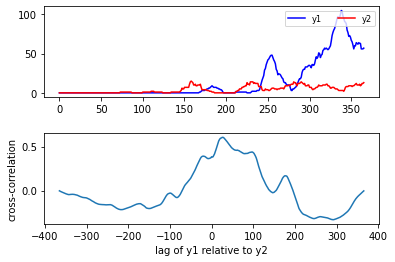

In [24]:
fig, axs = plt.subplots(nrows=2)
fig.subplots_adjust(hspace=0.4)
ax = axs[0]
ax.plot(baires.get(), 'b', label='y1')
ax.plot(caba.get(), 'r', label='y2')
ax.legend(loc='upper right', fontsize='small', ncol=2)

ax = axs[1]
ax.plot(lags.get(), ccor.get())
ax.set_ylabel('cross-correlation')
ax.set_xlabel('lag of y1 relative to y2')

maxlag = lags[cp.argmax(ccor)]
print("max correlation is %f" % cp.max(ccor))
print("max correlation is at lag %d" % maxlag)

# Ahora, lo hacemos en serio, tipo todas las provincias contra todas las provincias, y guardamos los resultados

In [25]:
localidades_lagmax = cp.zeros(shape=(rows,rows))
localidades_corrmax = cp.zeros(shape=(rows,rows))
npts = cols
lags = cp.arange(-npts + 1, npts)
i = 0
while i < rows:
    j = 0
    prov_tmp_1 = time_series_ac[i,:-10]
    while j < rows:
        prov_tmp_2 = time_series_ac[j,:-10]
        ccov = np.correlate(prov_tmp_1  - prov_tmp_1 .mean(), prov_tmp_2 - prov_tmp_2.mean(), mode='full')
        ccor = ccov / (npts * prov_tmp_1 .std() * prov_tmp_2.std())
        localidades_lagmax[i,j] = lags[cp.argmax(ccor)]
        localidades_corrmax[i,j] = cp.max(ccor)
        j = j + 1
    i = i +1

In [26]:
localidades_lagmax

array([[-10.,  17.,   1., ...,  53.,  44., -34.],
       [-37., -10., -47., ..., -10., -62., -92.],
       [-21.,  27., -10., ...,  56.,  28., -50.],
       ...,
       [-73., -10., -76., ..., -10., -22., -81.],
       [-64.,  42., -48., ...,   2., -10., -85.],
       [ 14.,  72.,  30., ...,  61.,  65., -10.]])